In [1]:
from dataclasses import dataclass, field
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from source.backends import udkm_backend, pr_backend
from source.core.atom import Atom
from source.core.formfactor import FormFactorModel
from source.core.structure import Structure
from source.core.compound import create_compound

import time
import statistics

It is required to define a class that specifies how the form factor is loaded

In [2]:
@dataclass
class FormFactorData(FormFactorModel):
    ff_data: pd.DataFrame | None = field(default=None)

    def __init__(self, ff_path: str):
        super().__init__(ff_path)
        self.read_data()

    def read_data(self):
        if self.ff_path is None:
            raise ValueError("Form factor path is not set.")
        
        file = Path(self.ff_path)
        if not file.exists():
            raise FileNotFoundError(f"Form factor data file '{self.ff_path}' does not exist.")
        
        self.ff_data = pd.read_csv(
            file,
            sep="\s+",
            header=None,
            index_col=False,
            names=["E", "f1", "f2"],
            dtype=float,
            comment="#",
        )

    def get_f1f2(self, energy_eV: float, *args) -> tuple[float, float]:
        if self.ff_data is None:
            raise ValueError("Form factor data has not been loaded.")
        
        f1 = float(np.interp(energy_eV, self.ff_data.E, self.ff_data.f1))
        f2 = float(np.interp(energy_eV, self.ff_data.E, self.ff_data.f2))
        
        return f1, f2
    
    def get_all_f1f2(self, *args) -> pd.DataFrame:
        if self.ff_data is None:
            raise ValueError("Form factor data has not been loaded.")
        
        return self.ff_data


<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/var/folders/5l/q_2fp3cx64xcj56lcg21ywvr0000gn/T/ipykernel_74316/3333019941.py:19: SyntaxWarning: invalid escape sequence '\s'
  sep="\s+",


In [3]:
def plot_reflectivity(qz, R_phi, R_pi, energy_eV, model_name):
    plt.figure(figsize=(8, 6))
    plt.semilogy(qz, R_phi, label=r"$\sigma$-pol")
    plt.semilogy(qz, R_pi, "--", label=r"$\pi$-pol")
    plt.xlabel(r"$q_z$ (Å$^{-1}$)")
    plt.ylabel(r"Reflectivity")
    plt.title(rf"Reflectivity for {model_name} at {energy_eV} eV")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_energy_scan(e_pr, R_phi_pr, R_pi_pr, theta_deg, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(e_pr, R_phi_pr, label=r"$\sigma$-pol")
    plt.plot(e_pr, R_pi_pr, "--", label=r"$\pi$-pol")
    plt.xlabel("Energy (eV)")
    plt.ylabel("Reflectivity")
    plt.title(rf"Energy Scan for {model_name} at {theta_deg}°")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized


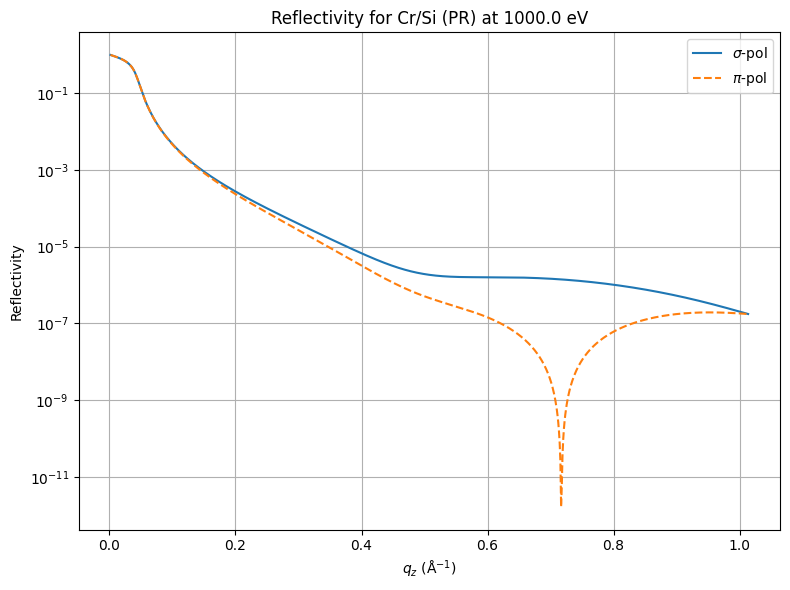

/Users/niaggar/Developer/mitacs/rxr-mask/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


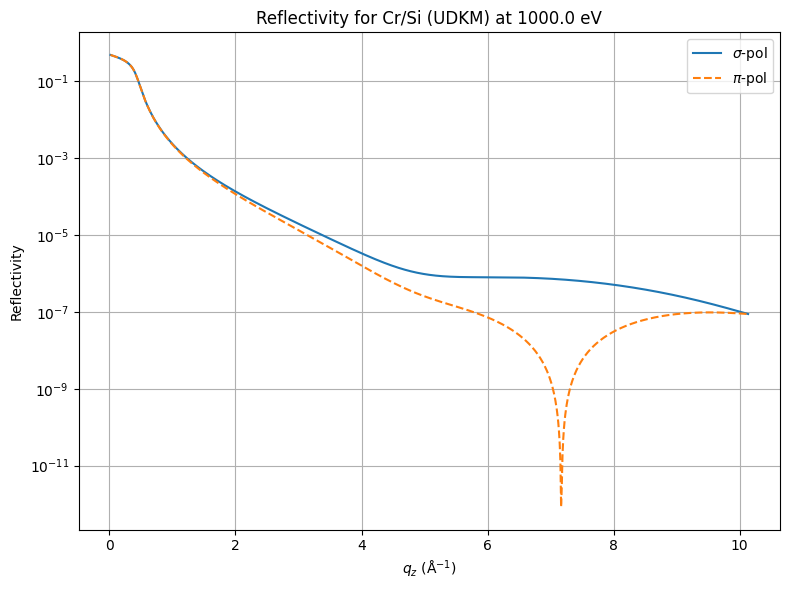

In [4]:
cr_ff = FormFactorData(ff_path="./source/materials/form_factor/Cr.txt")
si_ff = FormFactorData(ff_path="./source/materials/form_factor/Si.txt")
cr_atom = Atom(
    Z=24,
    name="Cr",
    symbol="Cr",
    ff=cr_ff,
)
si_atom = Atom(
    Z=14,
    name="Si",
    symbol="Si",
    ff=si_ff,
)


comp_cr = create_compound(
    id="Cr",
    name="Cr",
    thickness=10,
    density=5,
    formula="Cr:1",
    n_layers=1,
    atoms_prov=[cr_atom],
)
comp_si = create_compound(
    id="Si",
    name="Si",
    thickness=10,
    density=5,
    formula="Si:1",
    n_layers=1,
    atoms_prov=[si_atom],
)


struc = Structure(name="Cr/Si", n_compounds=2)
struc.add_compound(1, comp_si)
struc.add_compound(0, comp_cr)

E_eV = 1000.0
Theta = np.linspace(0.1, 89.1, num=1000)
qz = np.sin(Theta * np.pi / 180) * (E_eV * 0.001013546143)

qz_pr, R_phi_pr, R_pi_pr  = pr_backend.reflectivity(struc, qz, E_eV)
qz_ud, R_phi_ud, R_pi_ud,  = udkm_backend.reflectivity(struc, qz, E_eV)

plot_reflectivity(qz_pr, R_phi_pr, R_pi_pr, E_eV, "Cr/Si (PR)")
plot_reflectivity(qz_ud, R_phi_ud, R_pi_ud, E_eV, "Cr/Si (UDKM)")


# Test with LaMnO3 and SrTiO3

In [5]:
la_ff = FormFactorData(ff_path="./source/materials/form_factor/La.txt")
mn_ff = FormFactorData(ff_path="./source/materials/form_factor/Mn.txt")
o_ff = FormFactorData(ff_path="./source/materials/form_factor/O.txt")
sr_ff = FormFactorData(ff_path="./source/materials/form_factor/Sr.txt")
ti_ff = FormFactorData(ff_path="./source/materials/form_factor/Ti.txt")
c_ff = FormFactorData(ff_path="./source/materials/form_factor/C.txt")

In [6]:
la_atom = Atom(
    Z=57,
    name="La",
    symbol="La",
    ff=la_ff,
)
mn_atom = Atom(
    Z=25,
    name="Mn",
    symbol="Mn",
    ff=mn_ff,
)
o_atom = Atom(
    Z=8,
    name="O",
    symbol="O",
    ff=o_ff,
)
sr_atom = Atom(
    Z=38,
    name="Sr",
    symbol="Sr",
    ff=sr_ff,
)
ti_atom = Atom(
    Z=22,
    name="Ti",
    symbol="Ti",
    ff=ti_ff,
)
c_atom = Atom(
    Z=6,
    name="C",
    symbol="C",
    ff=c_ff,
)

In [12]:
comp_LaMnO3 = create_compound(
    id="LaMnO3",
    name="LaMnO:3",
    thickness=50.0,
    density=6.52,
    formula="La:1,Mn:1,O:3",
    n_layers=30,
    atoms_prov=[la_atom, mn_atom, o_atom],
)
comp_SrTiO3 = create_compound(
    id="SrTiO3",
    name="SrTiO:3",
    thickness=50.0,
    density=5.0,
    formula="Sr:1,Ti:1,O:3",
    n_layers=10,
    atoms_prov=[sr_atom, ti_atom, o_atom],
)
comp_CCO = create_compound(
    id="CCO",
    name="CCO",
    thickness=10,
    density=5,
    formula="C:1,O:1",
    n_layers=1,
    atoms_prov=[c_atom, o_atom],
)

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized


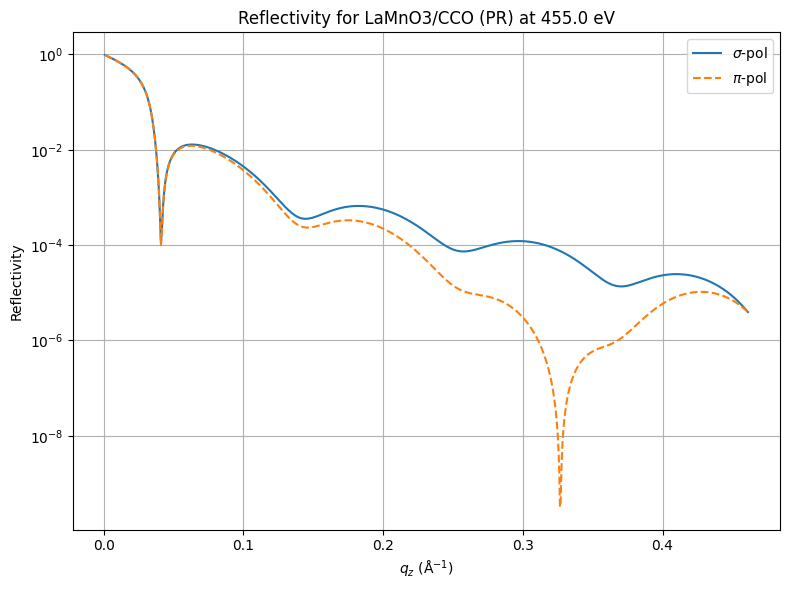

/Users/niaggar/Developer/mitacs/rxr-mask/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


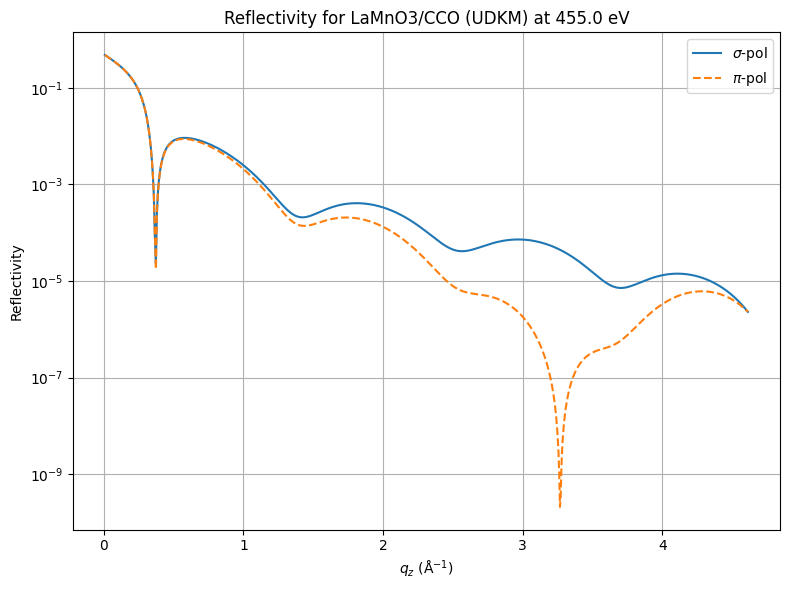

In [13]:
struc = Structure(name="LaMnO3/CCO", n_compounds=3)
struc.add_compound(2, comp_CCO)
struc.add_compound(1, comp_SrTiO3)
struc.add_compound(0, comp_LaMnO3)

E_eV = 455.0
Theta = np.linspace(0.1, 89.1, num=1000)
qz = np.sin(Theta * np.pi / 180) * (E_eV * 0.001013546143)

qz_pr, R_phi_pr, R_pi_pr  = pr_backend.reflectivity(struc, qz, E_eV)
qz_ud, R_phi_ud, R_pi_ud,  = udkm_backend.reflectivity(struc, qz, E_eV)

plot_reflectivity(qz_pr, R_phi_pr, R_pi_pr, E_eV, "LaMnO3/CCO (PR)")
plot_reflectivity(qz_ud, R_phi_ud, R_pi_ud, E_eV, "LaMnO3/CCO (UDKM)")

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized


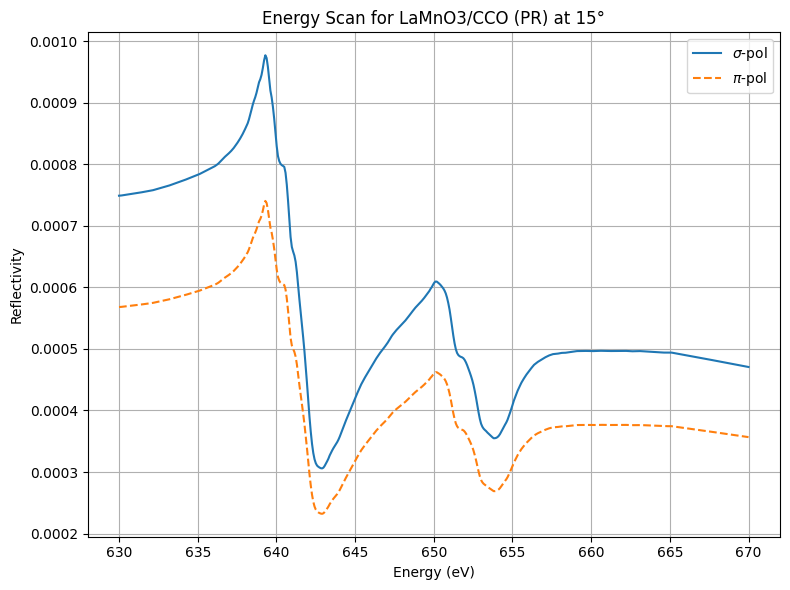

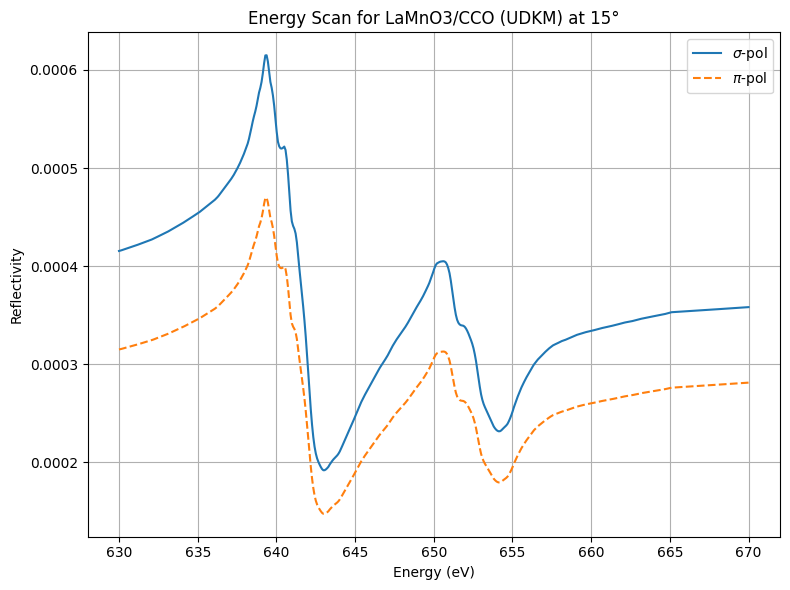

In [14]:
e_evs = np.linspace(630, 670, num=500).tolist()
theta_deg = 15

e_pr, R_phi_pr, R_pi_pr  = pr_backend.energy_scan(struc, e_evs, theta_deg)
e_ud, R_phi_ud, R_pi_ud = udkm_backend.energy_scan(struc, e_evs, theta_deg)

plot_energy_scan(e_pr, R_phi_pr, R_pi_pr, theta_deg, "LaMnO3/CCO (PR)")
plot_energy_scan(e_ud, R_phi_ud, R_pi_ud, theta_deg, "LaMnO3/CCO (UDKM)")